In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sklearn as sk
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn.model_selection import train_test_split

# structure of code largely based on tensorflow tutorial for deep neural nets: https://www.tensorflow.org/get_started/mnist/pros
# see full code of tutorial here: https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_deep.py

In [42]:
## Data ##

def read_file(filename):
    '''
    Parameters
    - filename: str
        File must be tab-delimited as follows: smiles code, tox21_id, label, fingerprint
    
    Returns
    - (X, Y): tuple of np.arrays
        X is an array of features
        Y is a vector of labels
    '''
    X = []
    Y = []
    input_file = open(filename, 'r')
    
    for index, line in enumerate(input_file):
        # split line (1 data point) into smiles, fingerprint (features), and label
        split_line = line.strip().split('\t')
        # print(index)
        # smiles = split_line[0]
        fingerprint = [int(c) for c in split_line[3]]
        label = int(split_line[2])
        
        # append data point to train_x (features) and train_y (labels)
        X.append(fingerprint)
        Y.append(label)
    input_file.close()
    return (np.array(X), np.array(Y))

train_filename = './fingerprints/train/nr-ahr.fp'
val_filename = './fingerprints/test/nr-ahr.fp'
test_filename = './fingerprints/score/nr-ahr.fp'
X_train, Y_train = read_file(train_filename)
X_val, Y_val = read_file(val_filename)
X_test, Y_test = read_file(test_filename)

In [40]:
## Model - basic ##

# Notes
# Probability of classifying into the positive class = sigmoid(logit)
# logit can take on any real value

def deepnn(x):
    """
    deepnn builds the graph for a deep net for learning the logit

    Args:
        x: an input tensor with the dimensions (batch_size, num_features)

    Returns:
        y: a tensor of length batch_size with values equal to the logits
            of classifying an input data point into the positive class
    """
    # tensorflow dense layer example: https://www.tensorflow.org/tutorials/layers#dense_layer
    
    scale = 0.1
    layer1 = tf.layers.dense(inputs=x, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer2 = tf.layers.dense(inputs=layer1, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer3 = tf.layers.dense(inputs=layer2, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer4 = tf.layers.dense(inputs=layer3, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer_out = tf.layers.dense(inputs=layer4, units=1, activation=None, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    return tf.squeeze(layer_out)

# sign tensorflow function
def sign_tf(x, threshold=0):
    return tf.cast(tf.greater_equal(x, threshold), tf.int32)

num_features = 881

# input
x = tf.placeholder(tf.float32, [None, num_features])

# loss weights for unbalanced data - https://stackoverflow.com/questions/35155655/loss-function-for-class-imbalanced-binary-classifier-in-tensor-flow
q = tf.placeholder(tf.float32, None)

# Define loss and optimizer
y_labels = tf.placeholder(tf.float32, [None]) # domain: {0,1}

# Build the graph for the deep net
y_pred = deepnn(x)
y_prob = tf.sigmoid(y_pred)

# logistic loss, aka sigmoid cross entropy
# y * -log(sigmoid(x)) + (1 - y) * -log(1 - sigmoid(x)), where x is the logit and y is the label
# loss_fn = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_labels, logits=y_pred))
loss_fn = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y_labels, logits=y_pred, pos_weight=q))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss_fn)

correct_prediction = tf.equal(sign_tf(y_pred), tf.cast(y_labels, tf.int32))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
#accuracy = tf.metrics.accuracy(labels=tf.cast(y_labels, tf.int32), predictions=sign_tf(y_pred))

In [ ]:
## Model - tunable ##

def deepnn_params(x, num_nodes=[1024], scale=[0.1], func=[tf.nn.relu]):
    """
    deepnn builds the graph for a deep net for learning the logit

    Args:
        x: an input tensor with dimensions (batch_size, num_features)
        num_nodes: a list of number of nodes in each layer. length = num_layers
        scale: a list of L2 regularization weights. length = num_layers
        func: a list of activation functions. length = num_layers

    Returns:
        y: a tensor of length batch_size with values equal to the logits
            of classifying an input data point into the positive class
    """
    # tensorflow dense layer example: https://www.tensorflow.org/tutorials/layers#dense_layer
    
    layers = []
    num_layers = len(units)
    layers.append(tf.layers.dense(inputs=x, units=num_nodes[0], activation=func[0], kernel_regularizer=tf.contrib.layers.l2_regularizer(scale[0])))
    for i in range(1,num_layers):
        tf.layers.dense(inputs=layers[i-1], units=num_nodes[i], activation=func[i], kernel_regularizer=tf.contrib.layers.l2_regularizer(scale[i]))
    return tf.squeeze(layers[-1])

# sign tensorflow function
def sign_tf(x, threshold=0):
    return tf.cast(tf.greater_equal(x, threshold), tf.int32)

# input
num_features = tf.placeholder(tf.int32, [None])
x = tf.placeholder(tf.float32, [None, num_features])

# labels
y_labels = tf.placeholder(tf.float32, [None]) # domain: {0,1}

# loss weights for unbalanced data - https://stackoverflow.com/questions/35155655/loss-function-for-class-imbalanced-binary-classifier-in-tensor-flow
q = tf.placeholder(tf.float32, [None])

# Build the graph for the deep net
num_layers = tf.placeholder(tf.int32, [None])
nodes = tf.placeholder(tf.float32, [None, num_layers])
funcs = tf.placeholder(tf.Tensor, [None, num_layers])
y_pred = deepnn_param(x, num_nodes=nodes, func=funcs)
y_prob = tf.sigmoid(y_pred)

# Define loss and optimizer
# logistic loss, aka sigmoid cross entropy
# y * -log(sigmoid(x)) + (1 - y) * -log(1 - sigmoid(x)), where x is the logit and y is the label
loss_fn = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y_labels, logits=y_pred, pos_weight=q))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss_fn)

correct_prediction = tf.equal(sign_tf(y_pred), tf.cast(y_labels, tf.int32))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
#accuracy = tf.metrics.accuracy(labels=tf.cast(y_labels, tf.int32), predictions=sign_tf(y_pred))

In [49]:
## Train model ##

# training parameters
batch_size = 50
num_epochs = 1
num_batches_per_epoch = int(np.ceil(len(X_train) / batch_size))
print(num_batches_per_epoch)

# calculate frequencies of positives, negatives in training set
q_train = Y_train.size/np.sum(Y_train)
q_val = Y_val.size/np.sum(Y_val)
print(q_train, q_val)
q_train = q_val

# keep track of loss and accuracy
train_losses = []
train_accs = []
val_losses = []
val_accs = []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# accuracy based on initialized weights
val_accuracy, val_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_val, y_labels: Y_val, q: q_train}) # use q_train or q_val??
train_accuracy, train_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_train, y_labels: Y_train, q: q_train}) # use q_train or q_val??
val_accs.append(val_accuracy)
val_losses.append(val_loss)
train_accs.append(train_accuracy)
train_losses.append(train_loss)
saver.save(sess, '/tmp/deepnn_model_weights.ckpt')
print('initial validation accuracy %0.3g' % val_accuracy)
print('initial validation loss %0.3g' % val_loss)

# hyperparameters
# num_layers = [1, 2, 3, 4]
# batch_sizes = [10, 50, 100, 500]
# num_nodes = [512, 1024, 2048]
# l2_scale = [0.01, 0.1, 1]

# training loop
for epoch in range(num_epochs):
    # shuffle indices of training data
    shuffle_indices = np.arange(len(X_train))
    np.random.shuffle(shuffle_indices)

    for i in range(num_batches_per_epoch):
        # get batch
        batch_indices = shuffle_indices[i*batch_size : (i+1)*batch_size]
        batch_x = X_train[batch_indices]
        batch_y = Y_train[batch_indices]

        # train on batch data
        sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y, q: q_train})

        # store loss and accuracy
        if i % 50 == 0:
            val_accuracy, val_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_val, y_labels: Y_val, q: q_train}) # use q_train or q_val??
            train_accuracy, train_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_train, y_labels: Y_train, q: q_train}) # use q_train or q_val??
            val_accs.append(val_accuracy)
            val_losses.append(val_loss)
            train_accs.append(train_accuracy)
            train_losses.append(train_loss)
            print('step %d, train loss: %0.3g,\t val loss: %0.3g,\t val acc: %0.3g\t' % (i, train_loss, val_loss, val_accuracy))

            # save variables only if accuracy has increased
            if val_accuracy > max(val_accs):
                saver.save(sess, 'deepnn_model_weights.ckpt')

val_accuracy = sess.run(accuracy, feed_dict={x: X_val, y_labels: Y_val})
if val_accuracy > max(val_accs):
    saver.save(sess, '/tmp/deepnn_model_weights.ckpt')

print("Best val accuracy: %g" % max(val_accs))

163
8.57894736842 9.03333333333
initial validation accuracy 0.889
initial validation loss 1.39
step 0, train loss: 1.51,	 val loss: 1.48,	 val acc: 0.889	
step 50, train loss: 0.911,	 val loss: 1.14,	 val acc: 0.679	
step 100, train loss: 0.777,	 val loss: 1.09,	 val acc: 0.624	
step 150, train loss: 0.731,	 val loss: 1.22,	 val acc: 0.531	
Best val accuracy: 0.889299


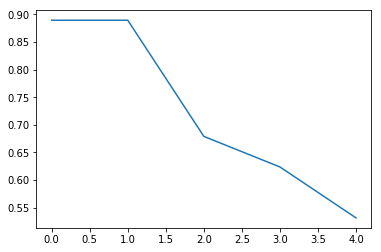

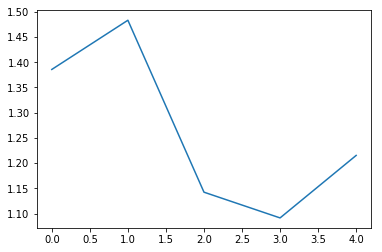

In [50]:
plt.figure()
plt.plot(val_accs)
plt.figure()
plt.plot(val_losses)

In [ ]:
## AUROC - manual calculation

def sign(x, threshold=0):
    y = x > threshold
    return y.astype(int)

# get normalized score, i.e. probability of classifying into positive class
score = sess.run(tf.sigmoid(y_pred), feed_dict={x: X_val, q: q_train})

numpoints_auroc = 100
sensitivity = np.zeros(numpoints_auroc)
specificity = np.zeros(numpoints_auroc)

print(np.sum(Y_val == 1))

thresholds = np.linspace(0, 1, num=numpoints_auroc)
for i in range(numpoints_auroc):
    # prediction = sess.run(sign_tf(score, thresholds[i]))
    prediction = sign(score, thresholds[i])
    c = sk.metrics.confusion_matrix(Y_val, prediction)
    tn, fp, fn, tp = c.ravel()
    sensitivity[i] = tp / (tp + fn)
    specificity[i] = tn / (tn + fp)

    
# print(sensitivity)
auroc_x = np.ones(numpoints_auroc) - specificity
sort_idx = np.argsort(auroc_x)
auroc_x = auroc_x[sort_idx].squeeze()
sensitivity = sensitivity[sort_idx].squeeze()
plt.figure()
plt.plot(auroc_x,sensitivity)

# calculate area under the curve
np.trapz(sensitivity,auroc_x,axis=0)

0.612546
[ 0.          0.          0.01244813  0.01244813  0.09543568  0.09543568
  0.09958506  0.09958506  0.10373444  0.10373444  0.12033195  0.12033195
  0.12863071  0.12863071  0.14522822  0.14522822  0.14937759  0.14937759
  0.16182573  0.16182573  0.18257261  0.18257261  0.19087137  0.19087137
  0.21991701  0.21991701  0.22406639  0.22406639  0.22821577  0.22821577
  0.29045643  0.29045643  0.39834025  0.39834025  0.41493776  0.41493776
  0.46058091  0.46058091  0.5560166   0.5560166   0.73029046  0.73029046
  0.90041494  0.90871369  1.        ]
[ 0.03333333  0.13333333  0.13333333  0.16666667  0.16666667  0.2         0.2
  0.23333333  0.23333333  0.26666667  0.26666667  0.33333333  0.33333333
  0.36666667  0.36666667  0.4         0.4         0.43333333  0.43333333
  0.53333333  0.53333333  0.56666667  0.56666667  0.6         0.6
  0.66666667  0.66666667  0.7         0.7         0.73333333  0.73333333
  0.76666667  0.76666667  0.8         0.8         0.83333333  0.83333333
  0.93

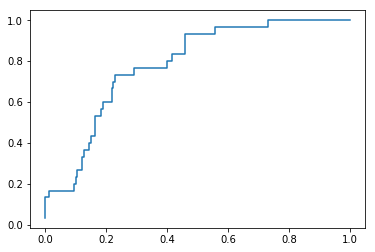

In [51]:
## AUROC - sklearn

def sign(x, threshold=0):
    y = x > threshold
    return y.astype(int)

# get normalized score, i.e. probability of classifying into positive class
score = sess.run(tf.sigmoid(y_pred), feed_dict={x: X_val, q: q_train})
val_accuracy, val_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_val, y_labels: Y_val, q: q_train}) # use q_train or q_val??
print(val_accuracy)

fpr, tpr, thresholds = sk.metrics.roc_curve(Y_val, score)
auc_roc = sk.metrics.auc(fpr, tpr)
print(fpr)
print(tpr)
print(auc_roc)

plt.figure()
plt.plot(fpr, tpr)

for t in thresholds:
    prediction = sign(score, t)
    c = sk.metrics.confusion_matrix(Y_val, prediction)
    print(c)

In [ ]:
## AUROC - tensorflow calculation

# correct_prediction = tf.equal(sign_tf(y_pred), tf.cast(y_labels, tf.int32))
# correct_prediction = tf.cast(correct_prediction, tf.float32)
# tmp = sess.run(correct_prediction, feed_dict={x: X_val, y_labels: Y_val})
# print(tmp)
# print(type(tmp))



# accuracy = tf.reduce_mean(correct_prediction)


# score = sess.run(tf.sigmoid(y_pred), feed_dict={x: X_val})
# auroc_fn = tf.metrics.auc(labels=Y_test, predictions=y_prob)
# sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
# auc, up_ops = tf.metrics.auc(labels=Y_val, predictions=y_prob)
# print(auroc)
auc, up_ops = tf.metrics.auc(labels=y_labels, predictions=y_prob)
print(auc)
print(up_ops)
auc, up_ops = sess.run([auc, up_ops], feed_dict={x: X_val, y_labels: Y_val})
print(auc)
print(up_ops)

In [ ]:
def compute_saliency_maps(batch_x, batch_y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    num_features = 881
    x = tf.placeholder(tf.float32, [None, num_features])
    y_labels = tf.placeholder(tf.float32, [None]) # domain: {0,1}
    
    y_pred = model(x)
    y_prob = tf.sigmoid(y_pred)
    
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    correct_scores = batch_y*y_prob + (1-batch_y)*(1-y_prob)
    
    saliency_vecs = None
    ###############################################################################
    # TODO: Implement this function. You should use the correct_scores to compute #
    # the loss, and tf.gradients to compute the gradient of the loss with respect #
    # to the input image stored in model.image.                                   #
    # Use the global sess variable to finally run the computation.                #
    # Note: model.image and model.labels are placeholders and must be fed values  #
    # when you call sess.run().                                                   #
    ###############################################################################
    dimage = tf.gradients(correct_scores, x)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        grads = sess.run(dimage, feed_dict={x: batch_x, y_labels: batch_y})[0]
    saliency_vecs = np.array(grads)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency_vecs

In [ ]:
saliency_vecs = compute_saliency_maps(X_train, Y_train, deepnn)
print(saliency_vecs.shape)

In [ ]:
# bar plot (mean + sample standard deviation) of saliency of all features
# see here for meaning of features: ftp://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.txt
mean_saliency = np.mean(saliency_vecs, axis=0)
stddev_saliency = np.std(saliency_vecs, axis=0, ddof=1)
plt.figure(figsize=(100,10))
plt.bar(range(881), mean_saliency, width=1, yerr=stddev_saliency)

In [ ]:
# bar plot (mean + sample standard deviation) of saliency of top n features
n_top = 10
n_bottom = 10
mean_saliency = np.mean(saliency_vecs, axis=0)
stddev_saliency = np.std(saliency_vecs, axis=0, ddof=1)

idx_sort = np.argsort(mean_saliency)

top_ind = idx_sort[-n_top:][::-1]
top_val = mean_saliency[top_ind]
top_std = stddev_saliency[top_ind]

plt.figure(figsize=(10,10))
plt.bar(range(n_top), top_val, width=1, yerr=top_std, tick_label=top_ind)
plt.xlabel('fingerprint index', fontsize='18')
plt.ylabel('gradient of predicted probability of toxicity', fontsize='18')
plt.title('Top 10 predictive features for toxicity', fontsize='24')

bottom_ind = idx_sort[0:n_bottom]
bottom_val = mean_saliency[bottom_ind]
bottom_std = stddev_saliency[bottom_ind]

plt.figure(figsize=(10,10))
plt.bar(range(n_bottom), bottom_val, width=1, yerr=bottom_std, tick_label=bottom_ind)
plt.xlabel('fingerprint index', fontsize='18')
plt.ylabel('gradient of predicted probability of toxicity', fontsize='18')
plt.title('Top 10 predictive features for non-toxicity', fontsize='24')

In [ ]:
sum_saliency = np.sum(saliency_vecs, axis=0)
print(sum_saliency.shape)
print(np.argmax(sum_saliency))
plt.bar(range(881), sum_saliency, 3)